<a href="https://colab.research.google.com/github/samueljaval/weather-prediction/blob/main/deepNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [269]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
import datetime

To have a better understanding of what's going on here and what data we are working with, I would suggest looking at the 'getData.ipynb' and 'linearRegression.ipynb' parts of the project. 

Let us read the csv file that we generated in the getData.ipynb portion of the project to extract the dataframe with all the data. To run this script, one must run getData.ipynb, download the csv file and import it here.

In [270]:
df = pd.read_csv('expanded_data.csv')

Just like what we did in the 'linearRegression.ipynb' script, let's use the periodicity of average temperature.

In [271]:
day_of_year = []
for day in df['date']:
  day = datetime.datetime.strptime(day, '%Y-%m-%d')
  day_of_year.append((day - pd.Timestamp(year=day.year, month=1, day=1)).days + 1)
df['day_of_year']=day_of_year

In [272]:
df = df.set_index('date')

Again, just like what we did in the 'linearRegression.ipynb' script, let's make a new dataframe with only the values from the previous days. 
That is because it doesn't make sense to predict features for a day when we already have the values of these features for that day. The new dataframe is called df2



In [273]:
columns = list(df.columns)
columns = list(filter(lambda x : x[-1]==')' or x == 'day_of_year',columns))
df2 = df[columns]

*According* to the TensorFlow documentation, it will be easier for the model to interpret a wind vector instead of wind direction and wind speed. So let's do this conversion. 

In [274]:
for i in range(1,4):
  wind_direction = df2.pop('winddirDegree(-'+str(i)+')')
  wind_speed = df2.pop('windspeedKmph(-'+str(i)+')')
  wind_dir_radian = wind_direction*np.pi / 180 
  df2['windVectorX('+str(i)+')'] = wind_speed * np.cos(wind_dir_radian)
  df2['windVectorY('+str(i)+')'] = wind_speed * np.sin(wind_dir_radian)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [275]:
df2.head()

,avgtempC(-1),avgtempC(-2),avgtempC(-3),maxtempC(-1),maxtempC(-2),maxtempC(-3),mintempC(-1),mintempC(-2),mintempC(-3),totalSnow_cm(-1),totalSnow_cm(-2),totalSnow_cm(-3),precipMM(-1),precipMM(-2),precipMM(-3),humidity(-1),humidity(-2),humidity(-3),visibility(-1),visibility(-2),visibility(-3),pressure(-1),pressure(-2),pressure(-3),cloudcover(-1),cloudcover(-2),cloudcover(-3),DewPointC(-1),DewPointC(-2),DewPointC(-3),WindChillC(-1),WindChillC(-2),WindChillC(-3),FeelsLikeC(-1),FeelsLikeC(-2),FeelsLikeC(-3),day_of_year,windVectorX(1),windVectorY(1),windVectorX(2),windVectorY(2),windVectorX(3),windVectorY(3)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-04,-13.0,-14.0,-9.0,-7.0,-3.0,-3.0,-20.0,-22.0,-21.0,0.2,0.0,0.9,0.0,0.0,1.0,98.38,97.71,97.29,1.67,1.42,2.25,1021.46,1021.12,1025.17,61.67,15.62,37.96,-13.38,-14.21,-9.58,-16.83,-15.62,-11.79,-16.83,-15.62,-11.79,4,-2.950531,6.070985,-0.750786,-3.969625,-4.916407,-5.218989
2009-01-05,-14.0,-13.0,-14.0,-4.0,-7.0,-3.0,-24.0,-20.0,-22.0,0.0,0.2,0.0,0.0,0.0,0.0,96.42,98.38,97.71,2.42,1.67,1.42,1019.62,1021.46,1021.12,18.25,61.67,15.62,-14.42,-13.38,-14.21,-18.29,-16.83,-15.62,-18.29,-16.83,-15.62,5,3.505441,-5.861807,-2.950531,6.070985,-0.750786,-3.969625
2009-01-06,-13.0,-14.0,-13.0,-8.0,-4.0,-7.0,-18.0,-24.0,-20.0,0.0,0.0,0.2,0.0,0.0,0.0,93.62,96.42,98.38,5.75,2.42,1.67,1015.38,1019.62,1021.46,58.50,18.25,61.67,-14.00,-14.42,-13.38,-18.12,-18.29,-16.83,-18.12,-18.29,-16.83,6,4.528791,-6.448601,3.505441,-5.861807,-2.950531,6.070985
2009-01-07,-12.0,-13.0,-14.0,-10.0,-8.0,-4.0,-15.0,-18.0,-24.0,2.7,0.0,0.0,3.1,0.0,0.0,98.00,93.62,96.42,3.46,5.75,2.42,1015.04,1015.38,1019.62,93.17,58.50,18.25,-11.71,-14.00,-14.42,-16.75,-18.12,-18.29,-16.75,-18.12,-18.29,7,-3.789913,8.251240,4.528791,-6.448601,3.505441,-5.861807
2009-01-08,-9.0,-12.0,-13.0,-7.0,-10.0,-8.0,-10.0,-15.0,-18.0,5.1,2.7,0.0,5.9,3.1,0.0,99.00,98.00,93.62,5.17,3.46,5.75,1014.83,1015.04,1015.38,100.00,93.17,58.50,-8.58,-11.71,-14.00,-14.50,-16.75,-18.12,-14.50,-16.75,-18.12,8,-2.277722,13.985739,-3.789913,8.251240,4.528791,-6.448601


Let the $y$ contain what we want to predict and the $X$ dataframe contain the feature we use to make our predictions.

In [276]:
to_predict = 'avgtempC'
y = df[to_predict]
X = df2

For some reason, TensorFlow won't accept parentheses as part of a valid scope name. Therefore, we change "feature(-i)" to "feature.i"

In [277]:
for col in X.columns: 
  new_col = col.replace("(",".")
  new_col = new_col.replace(")","")
  X = X.rename(columns={col:new_col})

We split our data into three sets. It is straighforward to understand what the train and test sets are for. The validation set will be used to look at the loss function during the training. This helps us see if our model has converged or not and if we to do more training or not. We are choosing to use 90% of the data for training, 5% for testing and 5% for validation. 

In [278]:
def split_data(X, y, train, test, validation):
  assert train + test + validation == 1
  X_train, X_split_again, y_train, y_split_again = train_test_split(X, y, test_size=test)
  X_test, X_validation, y_test, y_validation = train_test_split(X_split_again, y_split_again, test_size=validation, shuffle=True)
  return X_train, y_train, X_test, y_test, X_validation, y_validation

X_train, y_train, X_test, y_test, X_validation, y_validation = split_data(X, y, 0.9, 0.05, 0.05)

TensorFlow requires us to provide the column names in their own format, so that's what we're doing here. 

In [279]:
tf_columns = []
for i in X.columns: 
  tf_columns.append(tf.feature_column.numeric_column(i))

Now let's proceed to setting up our model. We define our model with two hidden layers each having 25 nodes. The activation function for the model will be the Rectifies Linear Unit (ReLU). ReLU is technically the default but I like to have it there to make it clear to the reader what we are doing. Finally we also set the 'batch_norm' parameter to True to specify that we want to do batch normalization after each hidden layer. The batch normalization can have to power of making the model train faster.  

In [280]:
model = tf.estimator.DNNRegressor(
    hidden_units=[25,25], 
    feature_columns=tf_columns, 
    activation_fn = tf.nn.relu, 
    batch_norm = True, 
    )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqpmi12lt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


This following input function is required by tensor flow to preperly format the data for the train, test and evaluate method. We set the batch size to 380 which is about 1/10 of the size of our dataset. The defaut for the number of epochs is None which means that tensor flow will just figure it out by itself and we don't have to specify a correct number ourselves.

In [281]:
def input_function(X, y, shuffle, num_epochs=None, batch_size=380):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

Now we proceed to the training part. We could've done without the for loop but this helps us for visulizing the progress of the loss during the training process. We use the evaluate method to get that loss value and putit in a list called evaluations. We also specify num_epochs = 1 because we only want to go over the dataset once fot this evaluate step. So we get 50 data points for that analysis. We have an overall of 50*200=10,000 steps. One step means that we are running through one batch. Our entire dataset can be divided into 10 batches (using our batch_size). So we have 10,000 / 10 = 1,000 epochs. One epochs correspond to when we run through the entire dataset once. 

In [ ]:
evaluations = []
for i in range(50):
    print(i)
    model.train(input_fn=input_function(X_train, y_train, True), steps=200)
    evaluations.append(model.evaluate(input_fn=input_function(X_validation,
                                                               y_validation,
                                                               False,
                                                               num_epochs=1,
                                                               )))

We here plot the loss (which is the Mean Squared Error) over the epochs. We see a good loss function graph that decreases over time similarly to exp(-x). That mean that training makes big corrections at the beginning and the makes smaller corrections until it's pretty much converged. 

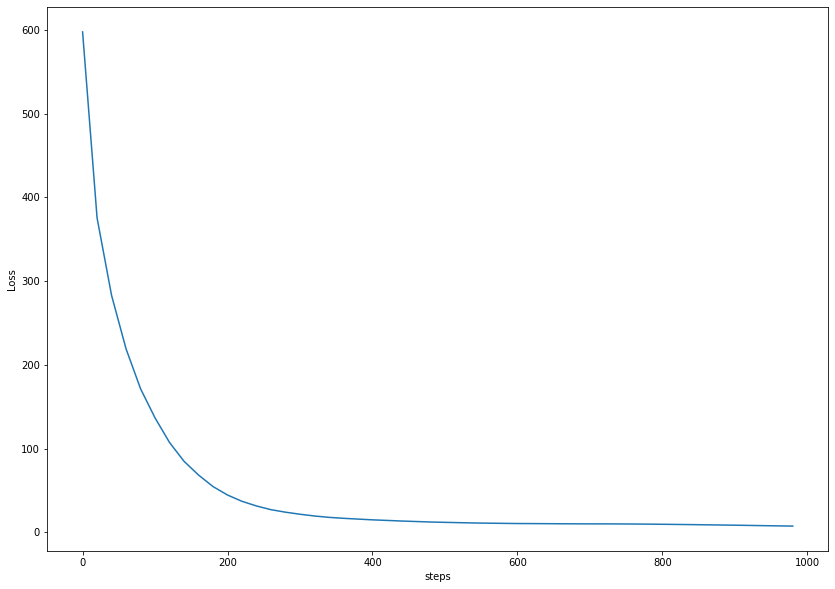

In [288]:
loss_lst = []
for x in evaluations: 
  loss_lst.append(x['loss'])

steps = [20*i for i in range(50)]

plt.plot(steps , loss_values)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

Now we make our predictions on the test set using the predict method. We set num_epochs = 1 because we only want to go over the dataset once for testing. 

In [ ]:
pred = model.predict(input_fn=input_function(X_test,
                                             y_test,
                                             False,
                                             num_epochs=1,
                                             ))

predictions = np.array([p['predictions'][0] for p in pred])

Let's have a look at how our model performed! 

In [285]:
print(f'accuracy = {str(explained_variance_score(y_test, predictions)*100)[0:5]}%')
print(f'mean absolute error = {str(mean_absolute_error(y_test, predictions))[0:5]}°C')

accuracy = 93.22%
mean absolute error = 2.033°C


In [286]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df2.head()

,Actual,Predicted
date,,
2016-02-22,-2,-6.043613
2012-08-16,13,10.181331
2017-03-25,-2,-4.359444
2015-06-14,5,5.010057
2015-08-30,10,9.876030


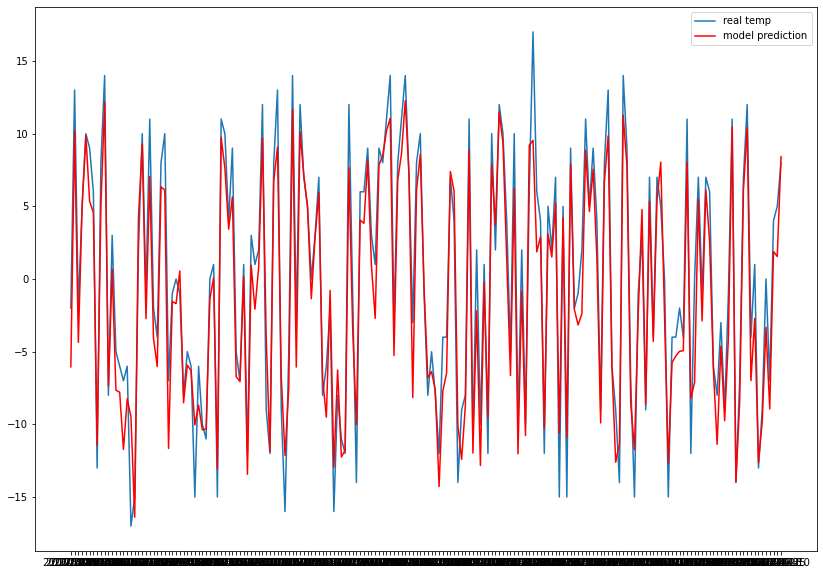

In [287]:
plt.plot(y_test, label="real temp")
plt.plot(predictions, 'r', label="model prediction")
plt.legend()